In [31]:
import numpy as np # linear algebra
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import time
%matplotlib inline
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split

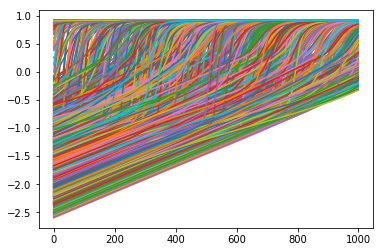

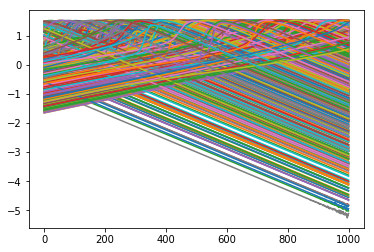

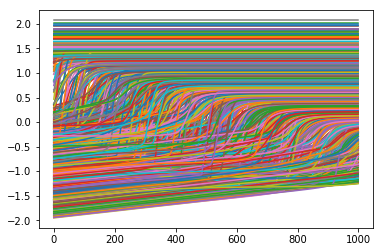

(800, 1000, 3) (800, 4) (200, 1000, 3) (200, 4)


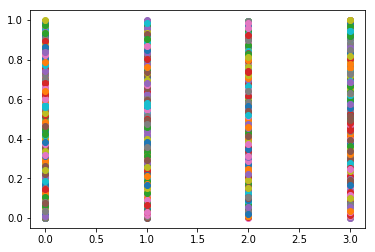

In [32]:
X=np.loadtxt('X.csv',delimiter=',')
Y=np.loadtxt('Y.csv',delimiter=',')

X=np.reshape(X,(-1,1000,3))

for i in range(3):
    mean=np.mean(X[:,:,i])
    std=np.std(X[:,:,i])
    X[:,:,i]=(X[:,:,i]-mean)/std

plt.plot(np.transpose(X[:,:,0]))
plt.show()
plt.plot(np.transpose(X[:,:,1]))
plt.show()
plt.plot(np.transpose(X[:,:,2]))
plt.show()

m=1
Y[:,:m]=np.log10(Y[:,:m])/4+0.5
Y[:,m:2*m]/=2
Y[:,2*m:3*m]=np.log10(Y[:,2*m:3*m])/2
Y[:,3*m:]=np.log10(np.abs(Y[:,3*m:]))/2

plt.plot(np.transpose(Y),'o')
    
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

print(np.shape(x_train),np.shape(y_train),np.shape(x_test),np.shape(y_test))

(1000, 1000, 3)


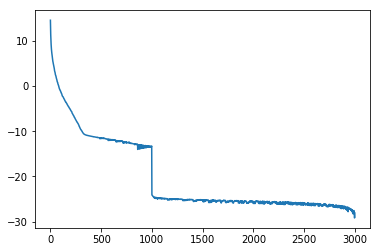

(1000, 3)


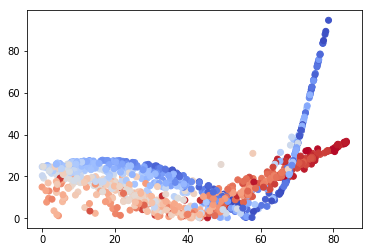

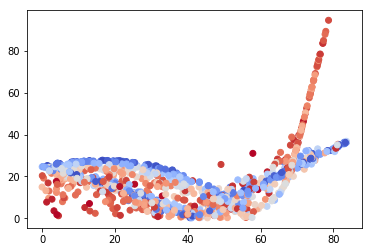

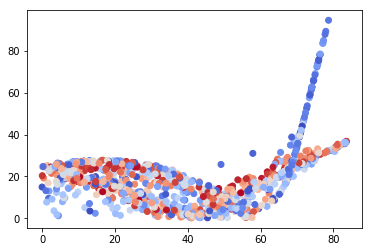

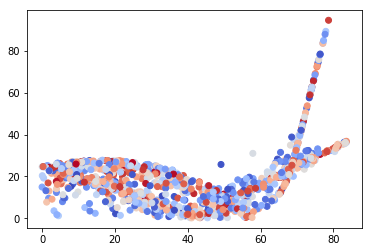

In [33]:
#Data Analysis
print(np.shape(X))
X = np.reshape(np.transpose(X,(0,2,1)),(-1,1000*3))
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)
X_=np.matrix.transpose(X)

lambd,W=np.linalg.eig(np.matmul(X_,X))

plt.plot(np.log(lambd))
plt.show()

Z=np.abs(np.matmul(X,W[:,:3]))
print(np.shape(Z))

for i in range(4):
    plt.scatter(Z[:,0],Z[:,1], c=Y[:,i], cmap="coolwarm")
    plt.show()



In [34]:
model = Sequential()

model.add(Flatten(input_shape=(1000,3)))
model.add(Dense(2048, activation='linear'))
model.add(LeakyReLU(alpha=.1))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(4046, activation='linear'))
model.add(LeakyReLU(alpha=.1))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(2048, activation='linear'))
model.add(LeakyReLU(alpha=.1))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(4*m, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              6146048   
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 2048)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 4046)              8290254   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 4046)              0         
__________

In [35]:
model.compile(loss='mean_squared_error', optimizer = Adam(lr=1e-4), metrics=["accuracy"]) #binary_crossentropy

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

hist = model.fit(x=x_train, y=y_train, batch_size=512,
                           epochs=20, #Increase this when not on Kaggle kernel
                           verbose=2,  #1 for ETA, 0 for silent
                           validation_data=(x_test, y_test), #For speed
                           callbacks=[annealer])

Train on 800 samples, validate on 200 samples
Epoch 1/20
 - 4s - loss: 0.1640 - acc: 0.4075 - val_loss: 0.2398 - val_acc: 0.4350
Epoch 2/20
 - 1s - loss: 0.1898 - acc: 0.4925 - val_loss: 0.2155 - val_acc: 0.4800
Epoch 3/20
 - 1s - loss: 0.1707 - acc: 0.5287 - val_loss: 0.2023 - val_acc: 0.5100
Epoch 4/20
 - 1s - loss: 0.1552 - acc: 0.5375 - val_loss: 0.2044 - val_acc: 0.4400
Epoch 5/20
 - 1s - loss: 0.1486 - acc: 0.5275 - val_loss: 0.2101 - val_acc: 0.4100
Epoch 6/20
 - 1s - loss: 0.1346 - acc: 0.5237 - val_loss: 0.2031 - val_acc: 0.4550
Epoch 7/20
 - 1s - loss: 0.1237 - acc: 0.5325 - val_loss: 0.2068 - val_acc: 0.4750
Epoch 8/20
 - 1s - loss: 0.1149 - acc: 0.5500 - val_loss: 0.2029 - val_acc: 0.4500
Epoch 9/20
 - 1s - loss: 0.1042 - acc: 0.5537 - val_loss: 0.2014 - val_acc: 0.4650
Epoch 10/20
 - 1s - loss: 0.0926 - acc: 0.5350 - val_loss: 0.1899 - val_acc: 0.4650
Epoch 11/20
 - 1s - loss: 0.0887 - acc: 0.5512 - val_loss: 0.1841 - val_acc: 0.4800
Epoch 12/20
 - 1s - loss: 0.0822 - acc:

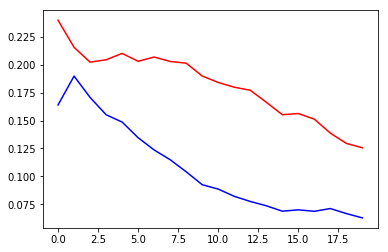

In [36]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()

In [37]:
model.evaluate(x_test, y_test)

200/200 [==============================] - 0s 685us/step


[0.12562933027744294, 0.535]

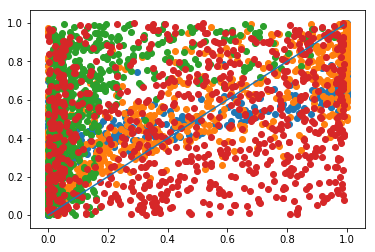

In [38]:
for i in range(4*m):
    plt.scatter(model.predict(x_train)[:,i],y_train[:,i])
plt.plot(np.arange(0,1,0.01),np.arange(0,1,0.01))
plt.show()

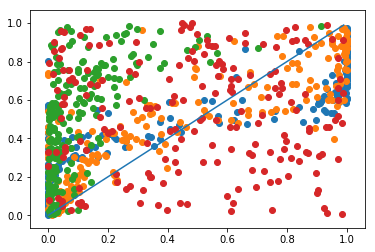

In [39]:
for i in range(4*m):
    plt.scatter(model.predict(x_test)[:,i],y_test[:,i])
plt.plot(np.arange(0,1,0.01),np.arange(0,1,0.01))
plt.show()